<a href="https://colab.research.google.com/github/RrePitso/customer_retention_predictive_analytics/blob/main/Customer_Retention_Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
demographics = pd.read_excel('/content/drive/MyDrive/Customer_Churn/Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Demographics')
churn = pd.read_excel('/content/drive/MyDrive/Customer_Churn/Customer_Churn_Data_Large.xlsx', sheet_name='Churn_Status')
transactions = pd.read_excel('/content/drive/MyDrive/Customer_Churn/Customer_Churn_Data_Large.xlsx', sheet_name='Transaction_History')
online = pd.read_excel('/content/drive/MyDrive/Customer_Churn/Customer_Churn_Data_Large.xlsx', sheet_name='Online_Activity')
service = pd.read_excel('/content/drive/MyDrive/Customer_Churn/Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Service')

In [ ]:
service.head()

,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


In [ ]:
# Aggregate Customer_Service: count interactions, unresolved issues
service_agg = service.groupby('CustomerID').agg({
    'InteractionID': 'count',
    'ResolutionStatus': lambda x: (x == 'Unresolved').sum()
}).reset_index().rename(columns={
    'InteractionID': 'TotalInteractions',
    'ResolutionStatus': 'UnresolvedIssues'
})

# Clean AmountSpent (handle comma decimal)
transactions['AmountSpent'] = transactions['AmountSpent'].astype(str).str.replace(',', '.').astype(float)


# Aggregate Transaction_History: average spend per customer
transaction_agg = transactions.groupby('CustomerID').agg({
    'AmountSpent': 'mean'
}).reset_index().rename(columns={'AmountSpent': 'AvgSpent'})



In [ ]:
service_agg.head()

,CustomerID,TotalInteractions,UnresolvedIssues
0,1,1,0
1,2,1,0
2,3,1,0
3,4,2,1
4,6,1,0


In [11]:
file_path = '/content/drive/MyDrive/Customer_Churn/cleaned_customer_data.csv'
df = pd.read_csv(file_path)
df.head()

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,LastLoginDate,LoginFrequency,ServiceUsage,TotalInteractions,UnresolvedIssues,AvgSpent
0,1,0,62,M,Single,Low,2023-10-21,34,Mobile App,1.0,0.0,416.50000
1,2,1,65,M,Married,Low,2023-12-05,5,Website,1.0,0.0,221.06000
2,3,0,18,M,Single,Low,2023-11-15,3,Website,1.0,0.0,283.83000
3,4,0,21,M,Widowed,Low,2023-08-25,2,Website,2.0,1.0,183.45800
4,5,0,21,M,Divorced,Medium,2023-10-27,41,Website,0.0,0.0,250.18625


In [12]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder


In [22]:
df['LastLoginDate'] = pd.to_datetime(df['LastLoginDate'])

# 2. Create a new feature: DaysSinceLastLogin
reference_date = df['LastLoginDate'].max()  # latest date in data as reference
df['DaysSinceLastLogin'] = (reference_date - df['LastLoginDate']).dt.days

# 3. Drop CustomerID and LastLoginDate columns (not predictive)
df = df.drop(columns=['CustomerID', 'LastLoginDate'])


KeyError: 'LastLoginDate'

In [23]:
df.head()

,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,LoginFrequency,ServiceUsage,TotalInteractions,UnresolvedIssues,AvgSpent,DaysSinceLastLogin
0,0,62,M,Single,Low,34,Mobile App,1.0,0.0,416.50000,71
1,1,65,M,Married,Low,5,Website,1.0,0.0,221.06000,26
2,0,18,M,Single,Low,3,Website,1.0,0.0,283.83000,46
3,0,21,M,Widowed,Low,2,Website,2.0,1.0,183.45800,128
4,0,21,M,Divorced,Medium,41,Website,0.0,0.0,250.18625,65


In [24]:
X = df.drop(columns=['ChurnStatus'])
y = df['ChurnStatus']

X.head()

,Age,Gender,MaritalStatus,IncomeLevel,LoginFrequency,ServiceUsage,TotalInteractions,UnresolvedIssues,AvgSpent,DaysSinceLastLogin
0,62,M,Single,Low,34,Mobile App,1.0,0.0,416.50000,71
1,65,M,Married,Low,5,Website,1.0,0.0,221.06000,26
2,18,M,Single,Low,3,Website,1.0,0.0,283.83000,46
3,21,M,Widowed,Low,2,Website,2.0,1.0,183.45800,128
4,21,M,Divorced,Medium,41,Website,0.0,0.0,250.18625,65


In [25]:
categorical_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1000 non-null   int64  
 1   LoginFrequency               1000 non-null   int64  
 2   TotalInteractions            1000 non-null   float64
 3   UnresolvedIssues             1000 non-null   float64
 4   AvgSpent                     1000 non-null   float64
 5   DaysSinceLastLogin           1000 non-null   int64  
 6   Gender_M                     1000 non-null   bool   
 7   MaritalStatus_Married        1000 non-null   bool   
 8   MaritalStatus_Single         1000 non-null   bool   
 9   MaritalStatus_Widowed        1000 non-null   bool   
 10  IncomeLevel_Low              1000 non-null   bool   
 11  IncomeLevel_Medium           1000 non-null   bool   
 12  ServiceUsage_Online Banking  1000 non-null   bool   
 13  ServiceUsage_Websit

In [26]:
bool_cols = ['Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed',
             'IncomeLevel_Low', 'IncomeLevel_Medium', 'ServiceUsage_Online Banking', 'ServiceUsage_Website']

X_encoded[bool_cols] = X_encoded[bool_cols].astype(int)
X_encoded.head()

,Age,LoginFrequency,TotalInteractions,UnresolvedIssues,AvgSpent,DaysSinceLastLogin,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Online Banking,ServiceUsage_Website
0,62,34,1.0,0.0,416.50000,71,1,0,1,0,1,0,0,0
1,65,5,1.0,0.0,221.06000,26,1,1,0,0,1,0,0,1
2,18,3,1.0,0.0,283.83000,46,1,0,1,0,1,0,0,1
3,21,2,2.0,1.0,183.45800,128,1,0,0,1,1,0,0,1
4,21,41,0.0,0.0,250.18625,65,1,0,0,0,0,1,0,1


In [54]:
y.head()

,ChurnStatus
0,0
1,1
2,0
3,0
4,0


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

# Creating model with class balancing
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

y_prob



array([0.31, 0.16, 0.12, 0.11, 0.18, 0.21, 0.26, 0.11, 0.28, 0.22, 0.13,
       0.23, 0.21, 0.26, 0.26, 0.33, 0.3 , 0.24, 0.21, 0.2 , 0.11, 0.34,
       0.34, 0.2 , 0.07, 0.11, 0.34, 0.15, 0.42, 0.09, 0.23, 0.34, 0.16,
       0.12, 0.07, 0.11, 0.16, 0.26, 0.17, 0.21, 0.23, 0.25, 0.44, 0.11,
       0.24, 0.12, 0.24, 0.06, 0.16, 0.16, 0.15, 0.05, 0.17, 0.13, 0.33,
       0.16, 0.19, 0.26, 0.08, 0.24, 0.19, 0.14, 0.17, 0.29, 0.18, 0.45,
       0.11, 0.21, 0.11, 0.25, 0.08, 0.52, 0.15, 0.19, 0.18, 0.09, 0.09,
       0.45, 0.25, 0.05, 0.22, 0.09, 0.3 , 0.15, 0.45, 0.18, 0.21, 0.37,
       0.09, 0.19, 0.24, 0.45, 0.22, 0.18, 0.49, 0.12, 0.47, 0.11, 0.48,
       0.07, 0.3 , 0.22, 0.38, 0.16, 0.15, 0.1 , 0.34, 0.15, 0.23, 0.08,
       0.26, 0.22, 0.24, 0.18, 0.27, 0.27, 0.16, 0.34, 0.08, 0.36, 0.07,
       0.41, 0.15, 0.09, 0.24, 0.27, 0.09, 0.35, 0.33, 0.15, 0.13, 0.31,
       0.32, 0.09, 0.2 , 0.12, 0.12, 0.18, 0.1 , 0.51, 0.17, 0.33, 0.26,
       0.06, 0.11, 0.14, 0.17, 0.16, 0.17, 0.32, 0.

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[157   2]
 [ 40   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88       159
           1       0.33      0.02      0.05        41

    accuracy                           0.79       200
   macro avg       0.57      0.51      0.46       200
weighted avg       0.70      0.79      0.71       200

ROC AUC Score: 0.4973155391931278


In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier on resampled data
rf_model_resampled = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_resampled.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_model_resampled.predict(X_test)
y_proba = rf_model_resampled.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[142  17]
 [ 37   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       159
           1       0.19      0.10      0.13        41

    accuracy                           0.73       200
   macro avg       0.49      0.50      0.48       200
weighted avg       0.67      0.73      0.69       200

ROC AUC Score: 0.5506979598097869


In [32]:
from xgboost import XGBClassifier

# Calculate imbalance ratio
pos_weight = (y == 0).sum() / (y == 1).sum()

# Step 4: Train XGBoost
xgb_model = XGBClassifier(
    learning_rate = 0.05,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Predict
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Step 6: Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[66 93]
 [13 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.42      0.55       159
           1       0.23      0.68      0.35        41

    accuracy                           0.47       200
   macro avg       0.53      0.55      0.45       200
weighted avg       0.71      0.47      0.51       200

ROC AUC Score: 0.5608222119957049


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Class Weighting Without SMOTE

In [33]:
# Train XGBoost without SMOTE
xgb_model_nosmote = XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=pos_weight,
    eval_metric='logloss',
    random_state=42
)
xgb_model_nosmote.fit(X_train, y_train)  # <-- Use original X_train

# Predict
y_pred_nosmote = xgb_model_nosmote.predict(X_test)
y_proba_nosmote = xgb_model_nosmote.predict_proba(X_test)[:, 1]

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nosmote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nosmote))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_nosmote))


Confusion Matrix:
[[122  37]
 [ 31  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       159
           1       0.21      0.24      0.23        41

    accuracy                           0.66       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.68      0.66      0.67       200

ROC AUC Score: 0.4756864549777573


LightGBM (with imbalance handling)

In [39]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Set up class weight
class_weight = (y == 0).sum() / (y == 1).sum()

# LightGBM model
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=3,
    class_weight={0: 1, 1: class_weight},  # adjust for imbalance
    random_state=42
)

# Fit model
lgb_model.fit(X_train, y_train)

# Predict
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 163, number of negative: 637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499615 -> initscore=-0.001540
[LightGBM] [Info] Start training from score -0.001540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

CatBoostClassifier with scale_pos_weight

In [40]:
!pip install catboost

In [44]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Calculate class imbalance ratio
pos_weight = (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()

# Step 2: Initialize CatBoost
catboost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.08,
    depth=8,
    scale_pos_weight=pos_weight,
    eval_metric='Logloss',
    random_seed=42,
    verbose=0  # suppress training output
)

# Step 3: Train the model
catboost_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Predict
y_pred = catboost_model.predict(X_test)
y_proba = catboost_model.predict_proba(X_test)[:, 1]

# Step 5: Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[142  17]
 [ 37   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       159
           1       0.19      0.10      0.13        41

    accuracy                           0.73       200
   macro avg       0.49      0.50      0.48       200
weighted avg       0.67      0.73      0.69       200

ROC AUC Score: 0.5626629851204172


In [45]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities for the positive class
y_proba = catboost_model.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.arange(0.0, 1.01, 0.05)
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f}, F1-score: {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\nBest threshold by F1-score: {best_threshold:.2f} with F1: {best_f1:.3f}")

# Use best threshold to predict
y_pred_best = (y_proba >= best_threshold).astype(int)

# Evaluate using best threshold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Threshold: 0.00, F1-score: 0.340
Threshold: 0.05, F1-score: 0.370
Threshold: 0.10, F1-score: 0.347
Threshold: 0.15, F1-score: 0.317
Threshold: 0.20, F1-score: 0.264
Threshold: 0.25, F1-score: 0.234
Threshold: 0.30, F1-score: 0.230
Threshold: 0.35, F1-score: 0.205
Threshold: 0.40, F1-score: 0.141
Threshold: 0.45, F1-score: 0.123
Threshold: 0.50, F1-score: 0.129
Threshold: 0.55, F1-score: 0.133
Threshold: 0.60, F1-score: 0.136
Threshold: 0.65, F1-score: 0.107
Threshold: 0.70, F1-score: 0.113
Threshold: 0.75, F1-score: 0.087
Threshold: 0.80, F1-score: 0.045
Threshold: 0.85, F1-score: 0.045
Threshold: 0.90, F1-score: 0.000
Threshold: 0.95, F1-score: 0.000
Threshold: 1.00, F1-score: 0.000

Best threshold by F1-score: 0.05 with F1: 0.370
Confusion Matrix:
[[ 46 113]
 [  6  35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.29      0.44       159
           1       0.24      0.85      0.37        41

    accuracy                 

RandomizedSearchCV for CatBoost

In [46]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

cat = CatBoostClassifier(scale_pos_weight=pos_weight, random_seed=42, verbose=0)

param_dist = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(cat, param_distributions=param_dist,
                                   n_iter=20, scoring=f1_scorer,
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", random_search.best_params_)
print("Best F1 score on CV:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 10, 'border_count': 64}
Best F1 score on CV: 0.7792925375706833


In [53]:
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report, roc_auc_score

neg = sum(y_train == 0)
pos = sum(y_train == 1)
pos_weight = neg / pos
print(f"Scale pos weight: {pos_weight:.2f}")

# Best parameters from your RandomizedSearchCV results
best_params = {
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 500,
    'depth': 10,
    'border_count': 64,
    'scale_pos_weight': pos_weight,  # Use your calculated pos_weight here
    'random_seed': 42,
    'verbose': 0
}

# 1. Retrain CatBoost on full training data
cat_best = CatBoostClassifier(**best_params)
cat_best.fit(X_train, y_train)

# 2. Get predicted probabilities for positive class (churn)
y_proba = cat_best.predict_proba(X_test)[:, 1]

# 3. Find the best threshold based on F1 score
thresholds = np.arange(0.0, 1.01, 0.05)
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f}, F1-score: {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\nBest threshold by F1-score: {best_threshold:.2f} with F1: {best_f1:.3f}")

# 4. Predict with the best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

# 5. Evaluate final model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")


Scale pos weight: 3.91
Threshold: 0.00, F1-score: 0.340
Threshold: 0.05, F1-score: 0.300
Threshold: 0.10, F1-score: 0.246
Threshold: 0.15, F1-score: 0.212
Threshold: 0.20, F1-score: 0.152
Threshold: 0.25, F1-score: 0.167
Threshold: 0.30, F1-score: 0.171
Threshold: 0.35, F1-score: 0.179
Threshold: 0.40, F1-score: 0.192
Threshold: 0.45, F1-score: 0.174
Threshold: 0.50, F1-score: 0.154
Threshold: 0.55, F1-score: 0.164
Threshold: 0.60, F1-score: 0.105
Threshold: 0.65, F1-score: 0.115
Threshold: 0.70, F1-score: 0.120
Threshold: 0.75, F1-score: 0.128
Threshold: 0.80, F1-score: 0.089
Threshold: 0.85, F1-score: 0.091
Threshold: 0.90, F1-score: 0.093
Threshold: 0.95, F1-score: 0.093
Threshold: 1.00, F1-score: 0.000

Best threshold by F1-score: 0.00 with F1: 0.340
Confusion Matrix:
[[  0 159]
 [  0  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       159
           1       0.20      1.00      0.34        41

    ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
print("Train set class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Train set class distribution:
ChurnStatus
0    0.5
1    0.5
Name: proportion, dtype: float64

Test set class distribution:
ChurnStatus
0    0.795
1    0.205
Name: proportion, dtype: float64


In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# Predict probabilities and classes on training data
y_train_proba = cat_best.predict_proba(X_train_resampled)[:, 1]

# Use 0.5 threshold for initial check
y_train_pred = (y_train_proba >= 0.5).astype(int)

print("Training Set Metrics (threshold=0.5):")
print(confusion_matrix(y_train_resampled, y_train_pred))
print(classification_report(y_train_resampled, y_train_pred))
print("ROC AUC Score:", roc_auc_score(y_train_resampled, y_train_proba))


Training Set Metrics (threshold=0.5):
[[637   0]
 [  0 637]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       637

    accuracy                           1.00      1274
   macro avg       1.00      1.00      1.00      1274
weighted avg       1.00      1.00      1.00      1274

ROC AUC Score: 1.0


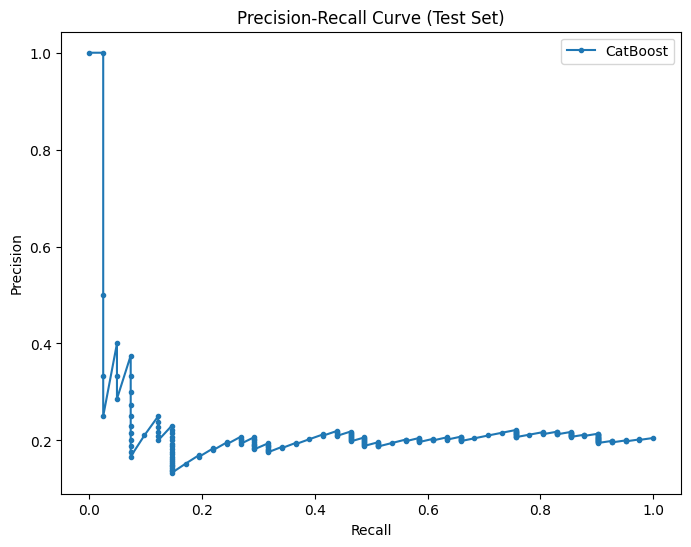

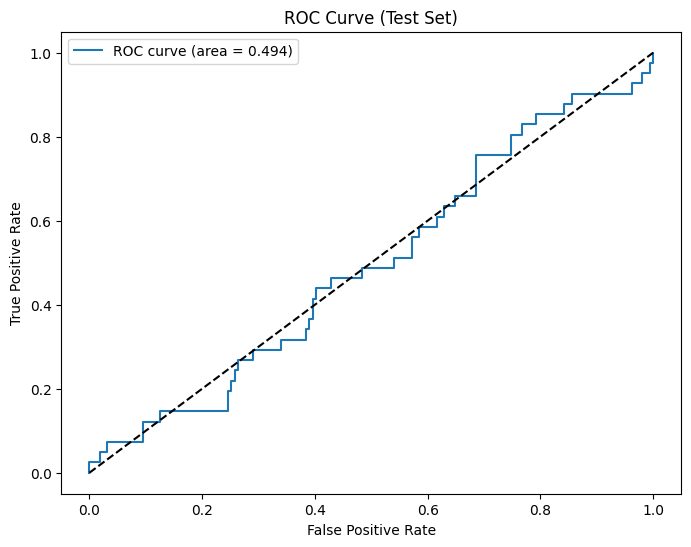

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()


In [51]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on the same resampled train data
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on test set
y_logreg_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate with default threshold 0.5
y_logreg_pred = (y_logreg_proba >= 0.5).astype(int)
print("Logistic Regression Performance on Test Set:")
print(confusion_matrix(y_test, y_logreg_pred))
print(classification_report(y_test, y_logreg_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_logreg_proba))


Logistic Regression Performance on Test Set:
[[127  32]
 [ 30  11]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       159
           1       0.26      0.27      0.26        41

    accuracy                           0.69       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.70      0.69      0.69       200

ROC AUC Score: 0.5921153551158154


Pipeline using CatBoost

In [55]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer

# Assuming X, y are your features and target (numpy arrays or pandas DataFrame/Series)

# Calculate scale_pos_weight for CatBoost (on full data)
pos_weight = (y == 0).sum() / (y == 1).sum()

print(f"Scale pos weight: {pos_weight:.2f}")

# Define CatBoost model without training yet
cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    scale_pos_weight=pos_weight,
    eval_metric='F1'
)

# Hyperparameter search space
param_dist = {
    'iterations': [200, 400, 600],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

# Use f1_score as scorer (binary classification)
f1_scorer = make_scorer(f1_score)

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store fold results
fold_metrics = {
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'threshold': []
}

# Cross-validation loop with hyperparameter tuning per fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_encoded, y), 1):
    print(f"Starting fold {fold}...")

    X_train_cv, X_val_cv = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Calculate pos_weight per fold (optional, but generally keep same for consistency)
    pos_weight_cv = (y_train_cv == 0).sum() / (y_train_cv == 1).sum()

    # Initialize model for this fold
    model = CatBoostClassifier(
        random_seed=42,
        verbose=0,
        scale_pos_weight=pos_weight_cv,
        eval_metric='F1'
    )

    # RandomizedSearchCV inside fold to tune hyperparams (reduce iterations and n_iter for speed)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        scoring=f1_scorer,
        cv=3,  # internal CV for hyperparam tuning
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train_cv, y_train_cv)
    best_model = random_search.best_estimator_

    # Predict probabilities on validation set
    y_val_proba = best_model.predict_proba(X_val_cv)[:, 1]

    # Tune threshold to maximize F1 on validation set
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_thresh = 0.5
    for t in thresholds:
        y_val_pred_t = (y_val_proba >= t).astype(int)
        f1 = f1_score(y_val_cv, y_val_pred_t)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    y_val_pred = (y_val_proba >= best_thresh).astype(int)

    # Calculate metrics
    precision = precision_score(y_val_cv, y_val_pred)
    recall = recall_score(y_val_cv, y_val_pred)
    roc_auc = roc_auc_score(y_val_cv, y_val_proba)

    # Store fold metrics
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(best_f1)
    fold_metrics['roc_auc'].append(roc_auc)
    fold_metrics['threshold'].append(best_thresh)

    print(f"Fold {fold} best threshold: {best_thresh:.2f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {best_f1:.3f}, ROC AUC: {roc_auc:.3f}\n")

# Summarize CV results
print("Cross-validation results:")
for metric in ['precision', 'recall', 'f1', 'roc_auc']:
    mean_val = np.mean(fold_metrics[metric])
    std_val = np.std(fold_metrics[metric])
    print(f"{metric.capitalize()}: {mean_val:.3f} ± {std_val:.3f}")

best_threshold = np.mean(fold_metrics['threshold'])
print(f"Average best threshold across folds: {best_threshold:.2f}")

# --- Retrain final model on full training data with best hyperparameters from CV ---

# Here, retrain on full X, y using best params found on CV
# (You can select best params by aggregating from folds or do a final RandomizedSearchCV on full train)

# For demonstration, retrain with default params + scale_pos_weight:
final_model = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    border_count=64,
    scale_pos_weight=pos_weight,
    random_seed=42,
    verbose=100
)

final_model.fit(X_encoded, y)

print("Final model trained on full data.")

# Save the best threshold for business usage
print(f"Use threshold ~{best_threshold:.2f} for classification decisions based on CV tuning.")


Scale pos weight: 3.90
Starting fold 1...
Fold 1 best threshold: 0.10
Precision: 0.201, Recall: 1.000, F1: 0.335, ROC AUC: 0.505

Starting fold 2...
Fold 2 best threshold: 0.10
Precision: 0.231, Recall: 0.878, F1: 0.365, ROC AUC: 0.537

Starting fold 3...
Fold 3 best threshold: 0.40
Precision: 0.286, Recall: 0.634, F1: 0.394, ROC AUC: 0.639

Starting fold 4...
Fold 4 best threshold: 0.20
Precision: 0.208, Recall: 0.976, F1: 0.343, ROC AUC: 0.480

Starting fold 5...
Fold 5 best threshold: 0.30
Precision: 0.231, Recall: 0.878, F1: 0.365, ROC AUC: 0.564

Cross-validation results:
Precision: 0.231 ± 0.030
Recall: 0.873 ± 0.129
F1: 0.361 ± 0.021
Roc_auc: 0.545 ± 0.055
Average best threshold across folds: 0.22
0:	learn: 0.6894442	total: 1.38ms	remaining: 551ms
100:	learn: 0.4361346	total: 118ms	remaining: 349ms
200:	learn: 0.2886515	total: 236ms	remaining: 234ms
300:	learn: 0.1894828	total: 354ms	remaining: 117ms
399:	learn: 0.1320326	total: 478ms	remaining: 0us
Final model trained on full d